# Dataset Loaded Through Kaggle API

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json  ~/.kaggle/

In [2]:
!kaggle datasets download -d kunalgupta2616/dog-vs-cat-images-data

 98% 972M/991M [00:07<00:00, 115MB/s] 
100% 991M/991M [00:07<00:00, 142MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dog-vs-cat-images-data.zip','r')
zip_ref.extractall()
zip_ref.close()

In [4]:
IMAGE_SIZE = [224,224] # Resize image for consistent size
train_path = '/content/dogcat/train'
validation_path = '/content/dogcat/validation'
test_path = '/content/dogcat/test1'


# Model Training

In [5]:
from tensorflow.keras.layers import Input,Dense,Flatten,Lambda
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

## Getting Pre-trained Model

In [6]:
vgg19 = VGG19(input_shape = IMAGE_SIZE + [3], weights = 'imagenet',include_top = False)

80134624/80134624 [==============================] - 0s 0us/step


In [7]:
for layer in vgg19.layers:
  print(layer)

In [8]:
# Don't train Existing Weights
for layer in vgg19.layers:
  layer.trainable = False

In [9]:
for layer in vgg19.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_conv4 False
block5_pool False


In [10]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

You can se Trainable params = 0, because we set that all layers should not be train

## Full Model

In [11]:
model = Sequential()

In [12]:
model.add(vgg19)
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(Dense(2,activation = 'softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 26447682 (100.89 MB)
Trainable params: 6423298 (24.50 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [14]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

## Data Augmentation

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size = IMAGE_SIZE,
                                              batch_size = 32,
                                              class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory(validation_path,
                                                        target_size = IMAGE_SIZE,
                                                        batch_size = 32,
                                                        class_mode = 'categorical')

Found 25000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


## Model Fitting

In [18]:
history = model.fit(
    train_set,
    validation_data = validation_set,
    epochs = 5,
    steps_per_epoch = len(train_set),
    validation_steps = len(validation_set)
)

Epoch 1/5
782/782 [==============================] - 395s 489ms/step - loss: 0.3583 - accuracy: 0.8678 - val_loss: 0.2028 - val_accuracy: 0.9174
Epoch 2/5
782/782 [==============================] - 380s 486ms/step - loss: 0.2202 - accuracy: 0.9064 - val_loss: 0.1681 - val_accuracy: 0.9283
Epoch 3/5
782/782 [==============================] - 381s 487ms/step - loss: 0.1994 - accuracy: 0.9156 - val_loss: 0.1793 - val_accuracy: 0.9254
Epoch 4/5
782/782 [==============================] - 385s 492ms/step - loss: 0.1889 - accuracy: 0.9205 - val_loss: 0.1535 - val_accuracy: 0.9335
Epoch 5/5
782/782 [==============================] - 385s 492ms/step - loss: 0.1813 - accuracy: 0.9248 - val_loss: 0.1349 - val_accuracy: 0.9485


## Plotting Result

In [19]:
import matplotlib.pyplot as plt

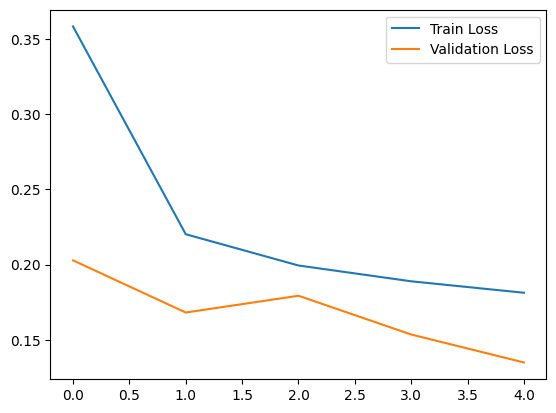

In [20]:
plt.plot(history.history['loss'],label = 'Train Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.legend()
plt.show()

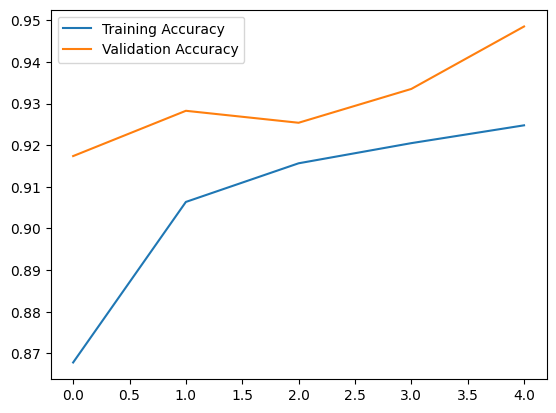

In [21]:
plt.plot(history.history['accuracy'],label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation Accuracy')
plt.legend()
plt.show()

## Save Model

In [22]:
from tensorflow.keras.models import save_model

In [23]:
# model.save('model_inception_net.keras')
model.save('vgg19.keras')
model.save('vgg19.h5')
model.save('vgg19.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Test Model

In [24]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = validation_datagen.flow_from_directory(test_path,
                                                        target_size = IMAGE_SIZE,
                                                        batch_size = 32)

Found 12500 images belonging to 1 classes.


In [25]:
y_pred = model.predict(test_set)

391/391 [==============================] - 62s 158ms/step


In [26]:
y_pred

array([[0.00153794, 0.9984621 ],
       [0.06526378, 0.93473625],
       [0.99219817, 0.00780179],
       ...,
       [0.99301517, 0.00698475],
       [0.9674385 , 0.03256148],
       [0.87305707, 0.126943  ]], dtype=float32)

In [27]:
y_pred = np.argmax(y_pred,axis = 1)

In [28]:
print(np.unique(y_pred,return_counts=True))

(array([0, 1]), array([5982, 6518]))


In [29]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt

In [30]:
def inference_img(img_path):

  z = plt.imread(img_path)
  plt.imshow(z)
  plt.show()

  img = load_img(img_path,target_size = (224,224))
  x = image.img_to_array(img)

  x = np.expand_dims(x,axis = 0)
  x = preprocess_input(x)

  y_pred = model.predict(x)
  print(y_pred)
  res = np.argmax(y_pred,axis = 1)
  if res[0] == 1:
    prediction = 'Dog'
    print(prediction)
  else:
    prediction = 'Cat'
    print(prediction)

In [31]:
from glob import glob
files = glob('/content/dogcat/test1/test1/*')

In [32]:
files_list = [i for i in files]

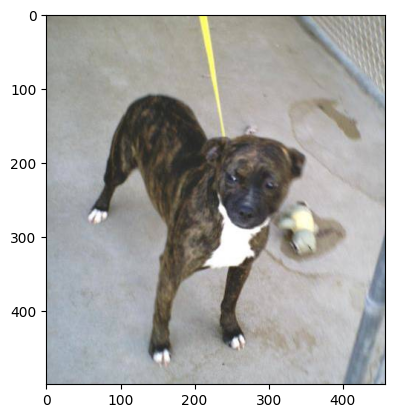

1/1 [==============================] - 1s 607ms/step
[[0. 1.]]
Dog


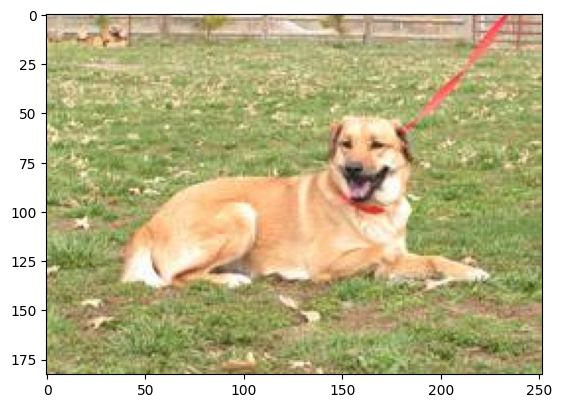

1/1 [==============================] - 0s 32ms/step
[[0. 1.]]
Dog


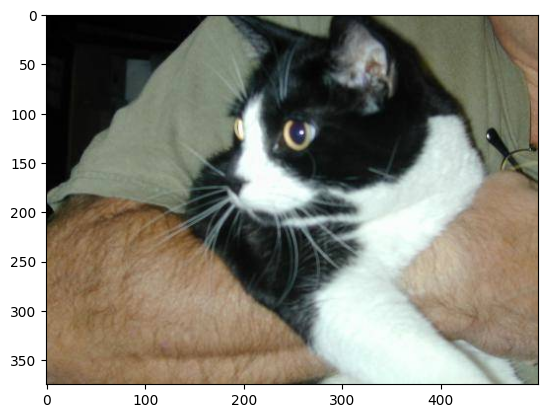

1/1 [==============================] - 0s 38ms/step
[[1. 0.]]
Cat


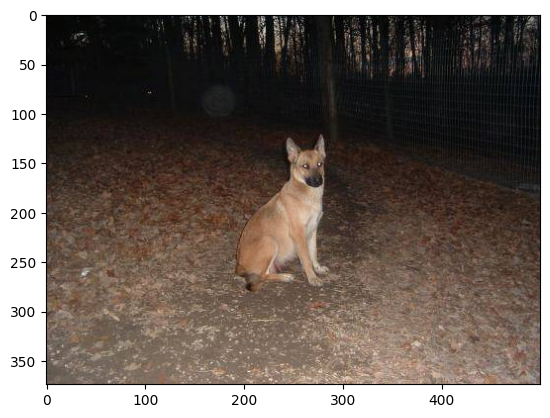

1/1 [==============================] - 0s 28ms/step
[[0. 1.]]
Dog


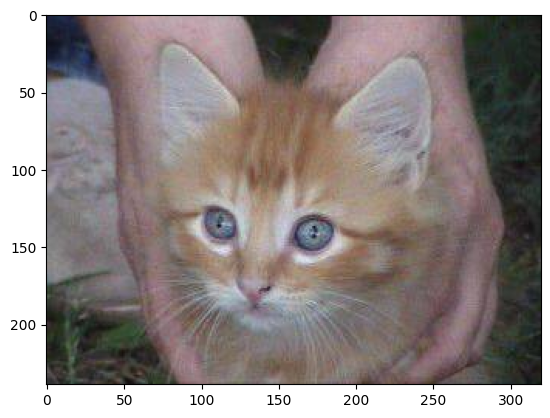

1/1 [==============================] - 0s 26ms/step
[[1. 0.]]
Cat


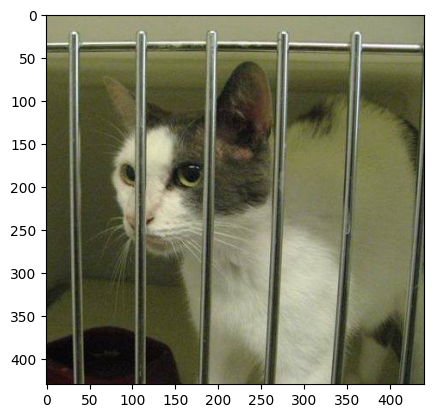

1/1 [==============================] - 0s 26ms/step
[[0. 1.]]
Dog


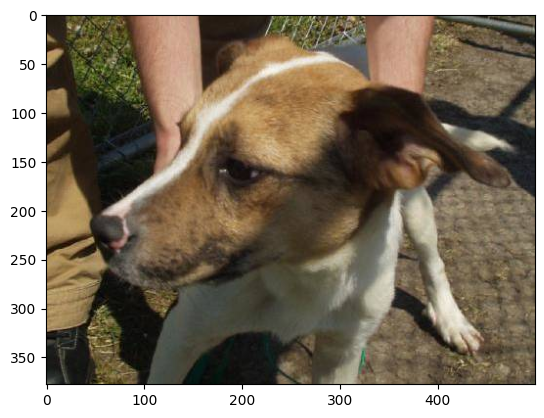

1/1 [==============================] - 0s 25ms/step
[[0. 1.]]
Dog


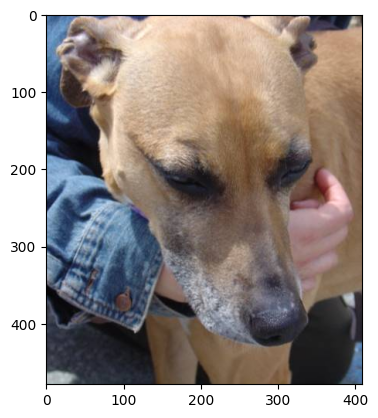

1/1 [==============================] - 0s 26ms/step
[[0. 1.]]
Dog


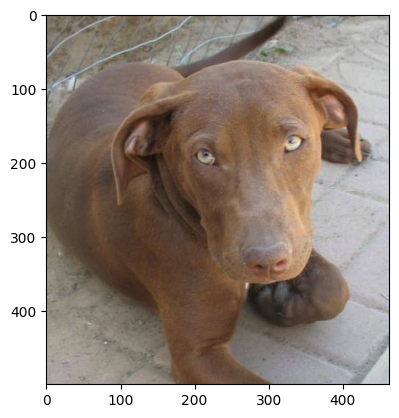

1/1 [==============================] - 0s 29ms/step
[[0. 1.]]
Dog


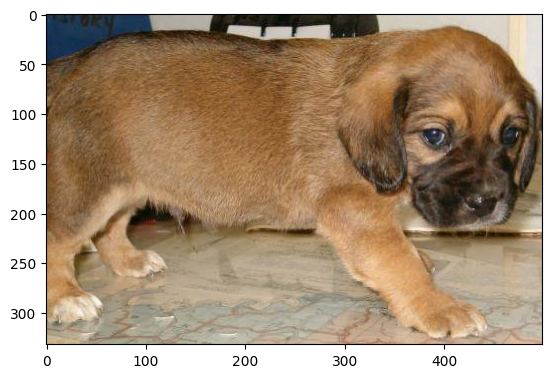

1/1 [==============================] - 0s 27ms/step
[[0. 1.]]
Dog


In [33]:
for i in range(10):
  inference_img(files_list[i])